In [1]:
import pandas as pd
import os,re
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from afinn import Afinn
from bs4 import BeautifulSoup
afinn = Afinn(language='en')

In [2]:
base_path = "/Users/leah/Desktop/NLP Group"

In [3]:
locations = pd.read_csv(base_path + os.sep + "locations.csv")  
locations_df = locations.dropna(axis=0,how='any') 
locations_df = locations_df[locations_df.Children==False]

In [4]:
locations_df

Date Company                                               Path  \
2     2010Q4     ABT  /pure_articles/ABT/2011-01-26T19:05:13-05:00_A...   
5     2010Q4     AMD  /pure_articles/AMD/2011-01-21T11:39:30-05:00_A...   
6     2010Q4    AMZN  /pure_articles/AMZN/2011-01-27T23:05:19-05:00_...   
8     2010Q4     BAC  /pure_articles/BAC/2011-01-21T16:05:23-05:00_B...   
9     2010Q4   CMCSA  /pure_articles/CMCSA/2011-02-16T15:30:00-05:00...   
...      ...     ...                                                ...   
2611  2022Q3    NVDA  /pure_articles/NVDA/2021-11-18T00:02:04-05:00_...   
2625  2022Q3     WMT  /pure_articles/WMT/2021-11-16T12:04:06-05:00_W...   
2638  2022Q4     CRM  /pure_articles/CRM/2022-03-01T21:18:01-05:00_S...   
2659  2022Q4    NVDA  /pure_articles/NVDA/2022-02-16T22:12:03-05:00_...   
2673  2022Q4     WMT  /pure_articles/WMT/2022-02-17T12:31:03-05:00_W...   

                   SpecificDate  Children  
2     2011-01-26T19:05:13-05:00     False  
5     2011-01-21T11:39:30-05:00     False  
6     2011-01-27T23:05:19-05:00     False  
8     2011-01-21T16:05:23-05:00     False  
9     2011-02-16T15:30:00-05:00     False  
...                         ...       ...  
2611  2021-11-18T00:02:04-05:00     False  
2625  2021-11-16T12:04:06-05:00     False  
2638  2022-03-01T21:18:01-05:00     False  
2659  2022-02-16T22:12:03-05:00     False  
2673  2022-02-17T12:31:03-05:00     False  

[2094 rows x 5 columns]

In [5]:
def clean_data(content):
    
    content = content.lower() # change to lower case for better data cleaning
    
    # remove html tags, when using BeautifulSoup, some texts occured to have TypeError, 
    # hence I define a cleaner using re.compile()function.
    
    try:
        cleaned_content = BeautifulSoup(content, 'html.parser').get_text() 
    except: 
        CLEANR = re.compile('<.*?>|&([a-z0-9]+|#[0-9]{1,6}|#x[0-9a-f]{1,6});')
        cleaned_content = re.sub(CLEANR, '', content)
    
    # lemmatize the words
    word_pattern = re.compile('\w+')
    words = word_pattern.findall(cleaned_content)
    lemma_content = [WordNetLemmatizer().lemmatize(w, pos='v') for w in words]

    # remove stopwords
    english_stop_words = stopwords.words('english')
    lemma_english_stopwords = [WordNetLemmatizer().lemmatize(w, pos='v') for w in english_stop_words]
    processed_content = [word for word in lemma_content if word not in lemma_english_stopwords]
    
    return processed_content

In [6]:
def get_data(index,afinn_dict):

    ticker = locations_df['Company'].iloc[index]
    file_path = locations_df['Path'].iloc[index]
    
    
    quarter = locations_df['Date'].iloc[index]
    date = locations_df['SpecificDate'].iloc[index][:10]
    
    f = open(base_path +file_path)
    content = f.read()
    
    # clean the texts
    processed_content = clean_data(content=content)

    # std_df is for temporary saving of sentiment scores of every word from the file now being processed
    std_df = {}
    std_df['word'] = pd.Series(processed_content)
    std_df['afinn_score'] = std_df['word'].apply(afinn.score)

    count = std_df['afinn_score'].count()
    afinn_score_sum =  std_df['afinn_score'].sum()
    afinn_score_mean = std_df['afinn_score'].mean()
    afinn_score_med = std_df['afinn_score'].median()
    afinn_score_std = std_df['afinn_score'].std()

    # preserve the results to the afinn_dict
    afinn_dict.update({file_path:{'Ticker':ticker,'Quarter':quarter,'Date':date,'Total_Words':count,'Sum': afinn_score_sum, 'Mean':afinn_score_mean,
                                    'Median':afinn_score_med, 'Std':afinn_score_std,
                                    '%Positive': ((std_df['afinn_score']>0).sum()/count*100),
                                    '%Negative': ((std_df['afinn_score']<0).sum()/count*100),
                                    '%Neutral': ((std_df['afinn_score']==0).sum()/count*100)}})


In [7]:
from multiprocess import Pool
from multiprocess import Manager
import time

In [8]:
if __name__ == '__main__':
    
    start_time = time.time()
    
    total = len(locations_df) # total number of loops
    # generating a shared dictionary through the pools to save and pass the results
    afinn_dict = Manager().dict() 
    
    p = Pool(10)
    for i in range(total):
        p.apply_async(get_data, args=(i , afinn_dict))
    p.close()
    p.join()
    
    print("--- %s seconds ---" % (time.time() - start_time)) # 73.26728177070618 seconds
    print('after pool:  {}'.format(afinn_dict))

--- 53.68369913101196 seconds ---
after pool:  {'/pure_articles/AMZN/2011-01-27T23:05:19-05:00_Amazon.com Management Discusses Q4 2010 Results - Earnings Call Transcript.html': {'Ticker': 'AMZN', 'Quarter': '2010Q4', 'Date': '2011-01-27', 'Total_Words': 3392, 'Sum': 549.0, 'Mean': 0.16185141509433962, 'Median': 0.0, 'Std': 0.6411945991983017, '%Positive': 9.286556603773585, '%Negative': 1.3561320754716981, '%Neutral': 89.35731132075472}, "/pure_articles/CMCSA/2011-02-16T15:30:00-05:00_Comcast's CEO Discusses Q4 2010 Results - Earnings Call Transcript.html": {'Ticker': 'CMCSA', 'Quarter': '2010Q4', 'Date': '2011-02-16', 'Total_Words': 4863, 'Sum': 751.0, 'Mean': 0.1544314209335801, 'Median': 0.0, 'Std': 0.5791918373622804, '%Positive': 9.747069710055522, '%Negative': 0.7814106518609911, '%Neutral': 89.47151963808349}, "/pure_articles/JNJ/2011-01-25T19:05:12-05:00_Johnson & Johnson's CEO Discusses Q4 2010 Results - Earnings Call Transcript.html": {'Ticker': 'JNJ', 'Quarter': '2010Q4', 'D

In [9]:
afinn_df = pd.DataFrame.from_dict(dict(afinn_dict), orient='index')
afinn_df = afinn_df.reset_index()
afinn_df = afinn_df.sort_values(by=['Ticker','Quarter'])
afinn_df = afinn_df.drop(['index'],axis = 1)

In [10]:
afinn_df 

Ticker Quarter        Date  Total_Words     Sum      Mean  Median  \
26     AAPL  2011Q1  2011-01-18         4455   578.0  0.129742     0.0   
60     AAPL  2011Q2  2011-04-20         4638   507.0  0.109314     0.0   
99     AAPL  2011Q3  2011-07-19         4522   546.0  0.120743     0.0   
141    AAPL  2011Q4  2011-10-18         4842   496.0  0.102437     0.0   
183    AAPL  2012Q1  2012-01-24         4676   481.0  0.102866     0.0   
...     ...     ...         ...          ...     ...       ...     ...   
1877    XOM  2020Q4  2021-02-02         6802   915.0  0.134519     0.0   
1922    XOM  2021Q1  2021-04-30         5874   779.0  0.132618     0.0   
1971    XOM  2021Q2  2021-07-30         6507  1021.0  0.156908     0.0   
2018    XOM  2021Q3  2021-10-29         5123   851.0  0.166114     0.0   
2064    XOM  2021Q4  2022-02-01         4721   883.0  0.187037     0.0   

           Std  %Positive  %Negative   %Neutral  
26    0.565632   7.856341   1.010101  91.133558  
60    0.559502   7.028892   1.573954  91.397154  
99    0.560846   7.386112   1.127820  91.486068  
141   0.534532   6.546881   1.239157  92.213961  
183   0.524791   6.501283   1.090676  92.408041  
...        ...        ...        ...        ...  
1877  0.583798   8.865040   1.955307  89.179653  
1922  0.562112   8.409942   1.702417  89.887640  
1971  0.580024   9.543568   1.229445  89.226986  
2018  0.619487  10.150303   1.659184  88.190513  
2064  0.633768  11.120525   1.165007  87.714467  

[2094 rows x 11 columns]

In [11]:
afinn_df.to_csv(base_path + os.sep + 'sentiment_data.csv',encoding='utf-8')

## Acquiring Stock Prices

In [12]:
import pandas_datareader as pdr
import datetime

In [13]:
tickers = afinn_df.Ticker.unique()

In [14]:
start_date = datetime.datetime(2011,1,1) #'2011-01-01'
end_date = datetime.datetime(2022,3,8) #'2022-03-08'
data = pdr.get_data_yahoo(tickers,start_date,end_date)

In [15]:
insert_prices = data.loc[:,'Adj Close'] # keep the adjusted close prices
insert_prices.columns.names = ['Ticker']
insert_prices = insert_prices.fillna(0)
insert_prices.to_csv('/Users/leah/Desktop/NLP Group/prices.csv',encoding = 'utf-8')
print(insert_prices)

Ticker            AAPL        ABBV         ABT         ACN        ADBE  \
Date                                                                     
2010-12-31    9.864281    0.000000   16.677650   39.143620   30.780001   
2011-01-03   10.078652    0.000000   16.646322   39.224335   31.290001   
2011-01-04   10.131256    0.000000   16.802963   38.966019   31.510000   
2011-01-05   10.214128    0.000000   16.802963   38.974091   32.220001   
2011-01-06   10.205877    0.000000   16.768154   39.119389   32.270000   
...                ...         ...         ...         ...         ...   
2022-03-02  166.559998  149.570007  120.360001  318.329987  471.179993   
2022-03-03  166.229996  150.410004  120.970001  318.950012  459.079987   
2022-03-04  163.169998  150.559998  121.410004  314.160004  452.130005   
2022-03-07  159.300003  149.449997  118.860001  305.019989  437.970001   
2022-03-08  157.440002  147.149994  116.110001  301.619995  431.529999   

Ticker             AMD         AMZN  

## Factor Analysis

In [16]:
import alphalens as al

In [17]:
factor_insert_df = pd.read_csv(base_path + os.sep + 'all_factors_value_insert_220318.csv') # factor dataset fulfilled daily, combined with complexity factors
factor_insert_df = factor_insert_df.iloc[:,1:]
factor_insert_df = factor_insert_df.drop(columns = ['Quarter'])
factor_insert_df = factor_insert_df.dropna()
factor_insert_df = factor_insert_df[(factor_insert_df.Ticker != 'ABBV') &(factor_insert_df.Ticker != 'FB')  ]

In [18]:
factor_insert_df

Ticker        Date  Total_Words     Sum      Mean  Median       Std  \
11       AAPL  2011-01-18       4969.0   830.0  0.167036     0.0  0.612760   
12       AAPL  2011-01-19       4969.0   830.0  0.167036     0.0  0.612760   
13       AAPL  2011-01-20       4969.0   830.0  0.167036     0.0  0.612760   
14       AAPL  2011-01-21       4969.0   830.0  0.167036     0.0  0.612760   
15       AAPL  2011-01-24       4969.0   830.0  0.167036     0.0  0.612760   
...       ...         ...          ...     ...       ...     ...       ...   
135115    XOM  2022-03-02       5719.0  1231.0  0.215247     0.0  0.660168   
135116    XOM  2022-03-03       5719.0  1231.0  0.215247     0.0  0.660168   
135117    XOM  2022-03-04       5719.0  1231.0  0.215247     0.0  0.660168   
135118    XOM  2022-03-07       5719.0  1231.0  0.215247     0.0  0.660168   
135119    XOM  2022-03-08       5719.0  1231.0  0.215247     0.0  0.660168   

        %Positive  %Negative   %Neutral  Flesch score  \
11       9.579392   0.905615  89.514993         60.02   
12       9.579392   0.905615  89.514993         60.02   
13       9.579392   0.905615  89.514993         60.02   
14       9.579392   0.905615  89.514993         60.02   
15       9.579392   0.905615  89.514993         60.02   
...           ...        ...        ...           ...   
135115  12.222417   0.961707  86.815877         52.58   
135116  12.222417   0.961707  86.815877         52.58   
135117  12.222417   0.961707  86.815877         52.58   
135118  12.222417   0.961707  86.815877         52.58   
135119  12.222417   0.961707  86.815877         52.58   

        Polysyllable number per sentence  Adj_close  
11                                  2.30  10.417494  
12                                  2.30  10.362145  
13                                  2.30  10.173760  
14                                  2.30   9.991499  
15                                  2.30  10.319636  
...                                  ...        ...  
135115                              3.71  80.529999  
135116                              3.71  81.040001  
135117                              3.71  84.089996  
135118                              3.71  87.120003  
135119                              3.71  87.779999  

[129479 rows x 13 columns]

In [19]:
insert_prices = insert_prices.drop(columns = ['ABBV', 'FB']) #abandon the stocks without a complete dataset

In [20]:
insert_prices

Ticker            AAPL         ABT         ACN        ADBE         AMD  \
Date                                                                     
2010-12-31    9.864281   16.677650   39.143620   30.780001    8.180000   
2011-01-03   10.078652   16.646322   39.224335   31.290001    8.470000   
2011-01-04   10.131256   16.802963   38.966019   31.510000    8.770000   
2011-01-05   10.214128   16.802963   38.974091   32.220001    8.910000   
2011-01-06   10.205877   16.768154   39.119389   32.270000    8.690000   
...                ...         ...         ...         ...         ...   
2022-03-02  166.559998  120.360001  318.329987  471.179993  118.279999   
2022-03-03  166.229996  120.970001  318.950012  459.079987  111.980003   
2022-03-04  163.169998  121.410004  314.160004  452.130005  108.410004   
2022-03-07  159.300003  118.860001  305.019989  437.970001  102.949997   
2022-03-08  157.440002  116.110001  301.619995  431.529999  105.529999   

Ticker             AMZN        AVGO        BAC      CMCSA        COST  ...  \
Date                                                                   ...   
2010-12-31   180.000000   21.819702  11.432378   8.905637   54.390957  ...   
2011-01-03   184.220001   21.351204  12.160830   9.106949   54.586769  ...   
2011-01-04   185.009995   21.504814  12.203681   9.135448   54.481346  ...   
2011-01-05   187.419998   21.497131  12.426499   9.257577   53.472000  ...   
2011-01-06   185.860001   21.904186  12.375076   9.265718   53.215889  ...   
...                 ...         ...        ...        ...         ...  ...   
2022-03-02  3041.050049  581.845459  42.950001  46.380001  528.000000  ...   
2022-03-03  2957.969971  574.713623  42.490002  47.119999  533.049988  ...   
2022-03-04  2912.820068  591.986877  40.950001  47.209999  525.500000  ...   
2022-03-07  2749.060059  566.866760  38.340000  46.299999  528.520020  ...   
2022-03-08  2720.290039  572.081482  38.590000  46.130001  523.359985  ...   

Ticker              T         TMO        TSLA         UNH         UPS  \
Date                                                                    
2010-12-31  15.136619   53.013599    5.326000   30.371180   52.139847   
2011-01-03  15.286025   54.066978    5.324000   31.229078   52.405636   
2011-01-04  15.394217   54.315956    5.334000   31.515024   52.290699   
2011-01-05  15.445733   54.124428    5.366000   31.615969   52.369740   
2011-01-06  15.236659   54.181904    5.576000   32.272011   52.075188   
...               ...         ...         ...         ...         ...   
2022-03-02  23.820000  556.450012  879.890015  485.380005  211.460007   
2022-03-03  23.910000  554.289978  839.289978  486.589996  212.429993   
2022-03-04  23.870001  547.320007  838.289978  498.649994  210.389999   
2022-03-07  23.570000  534.750000  804.580017  486.869995  201.179993   
2022-03-08  23.000000  524.000000  824.400024  473.459991  203.410004   

Ticker               V         VZ        WFC         WMT        XOM  
Date                                                                 
2010-12-31   16.215261  21.398895  22.690760   41.457081  46.899609  
2011-01-03   16.247530  21.787642  23.122749   41.941364  47.816818  
2011-01-04   16.265953  22.224228  23.174007   42.102795  48.041317  
2011-01-05   16.609243  22.529243  23.701185   41.826061  47.913021  
2011-01-06   16.858063  21.952402  23.540106   41.480133  48.220917  
...                ...        ...        ...         ...        ...  
2022-03-02  208.479996  54.139999  52.220001  136.160004  80.529999  
2022-03-03  207.229996  54.660000  51.240002  139.289993  81.040001  
2022-03-04  200.289993  55.110001  48.790001  142.820007  84.089996  
2022-03-07  190.699997  54.680000  45.810001  141.669998  87.120003  
2022-03-08  191.710007  53.250000  46.459999  138.740005  87.779999  

[2815 rows x 46 columns]

In [21]:
def factor_analysis(factor):
    factors = factor_insert_df[['Ticker','Date',factor]]

    factors['Date'] = pd.to_datetime(factors['Date'], format = '%Y-%m-%d') # change date to time series
    factors = factors.set_index(['Date','Ticker']) # set multi-index

    factors[factor] = factors[factor].astype(float)
    data = al.utils.get_clean_factor_and_forward_returns(factors, insert_prices, quantiles=4,bins=None, periods=(1,5,10)) # 1-period forward
    al.tears.create_full_tear_sheet(data) # visualize the results

/var/folders/1f/ctsn5f0x2j1bynwzccj_sn2m0000gn/T/ipykernel_30547/1615834402.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  factors['Date'] = pd.to_datetime(factors['Date'], format = '%Y-%m-%d') # change date to time series


Dropped 0.4% entries from factor data: 0.4% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!
Quantiles Statistics


min       max      mean       std  count    count %
factor_quantile                                                          
1                0.088869  0.166637  0.142373  0.013242  33660  26.089181
2                0.129081  0.187628  0.164778  0.008826  30871  23.927484
3                0.139932  0.202405  0.179752  0.009072  30943  23.983289
4                0.163636  0.252572  0.201395  0.013383  33545  26.000047

Returns Analysis


1D     5D    10D
Ann. alpha                                     0.032  0.021  0.019
beta                                          -0.050 -0.038 -0.034
Mean Period Wise Return Top Quantile (bps)     0.798  0.779  0.739
Mean Period Wise Return Bottom Quantile (bps) -0.328  0.175  0.213
Mean Period Wise Spread (bps)                  1.127  0.603  0.528

<Figure size 432x288 with 0 Axes>

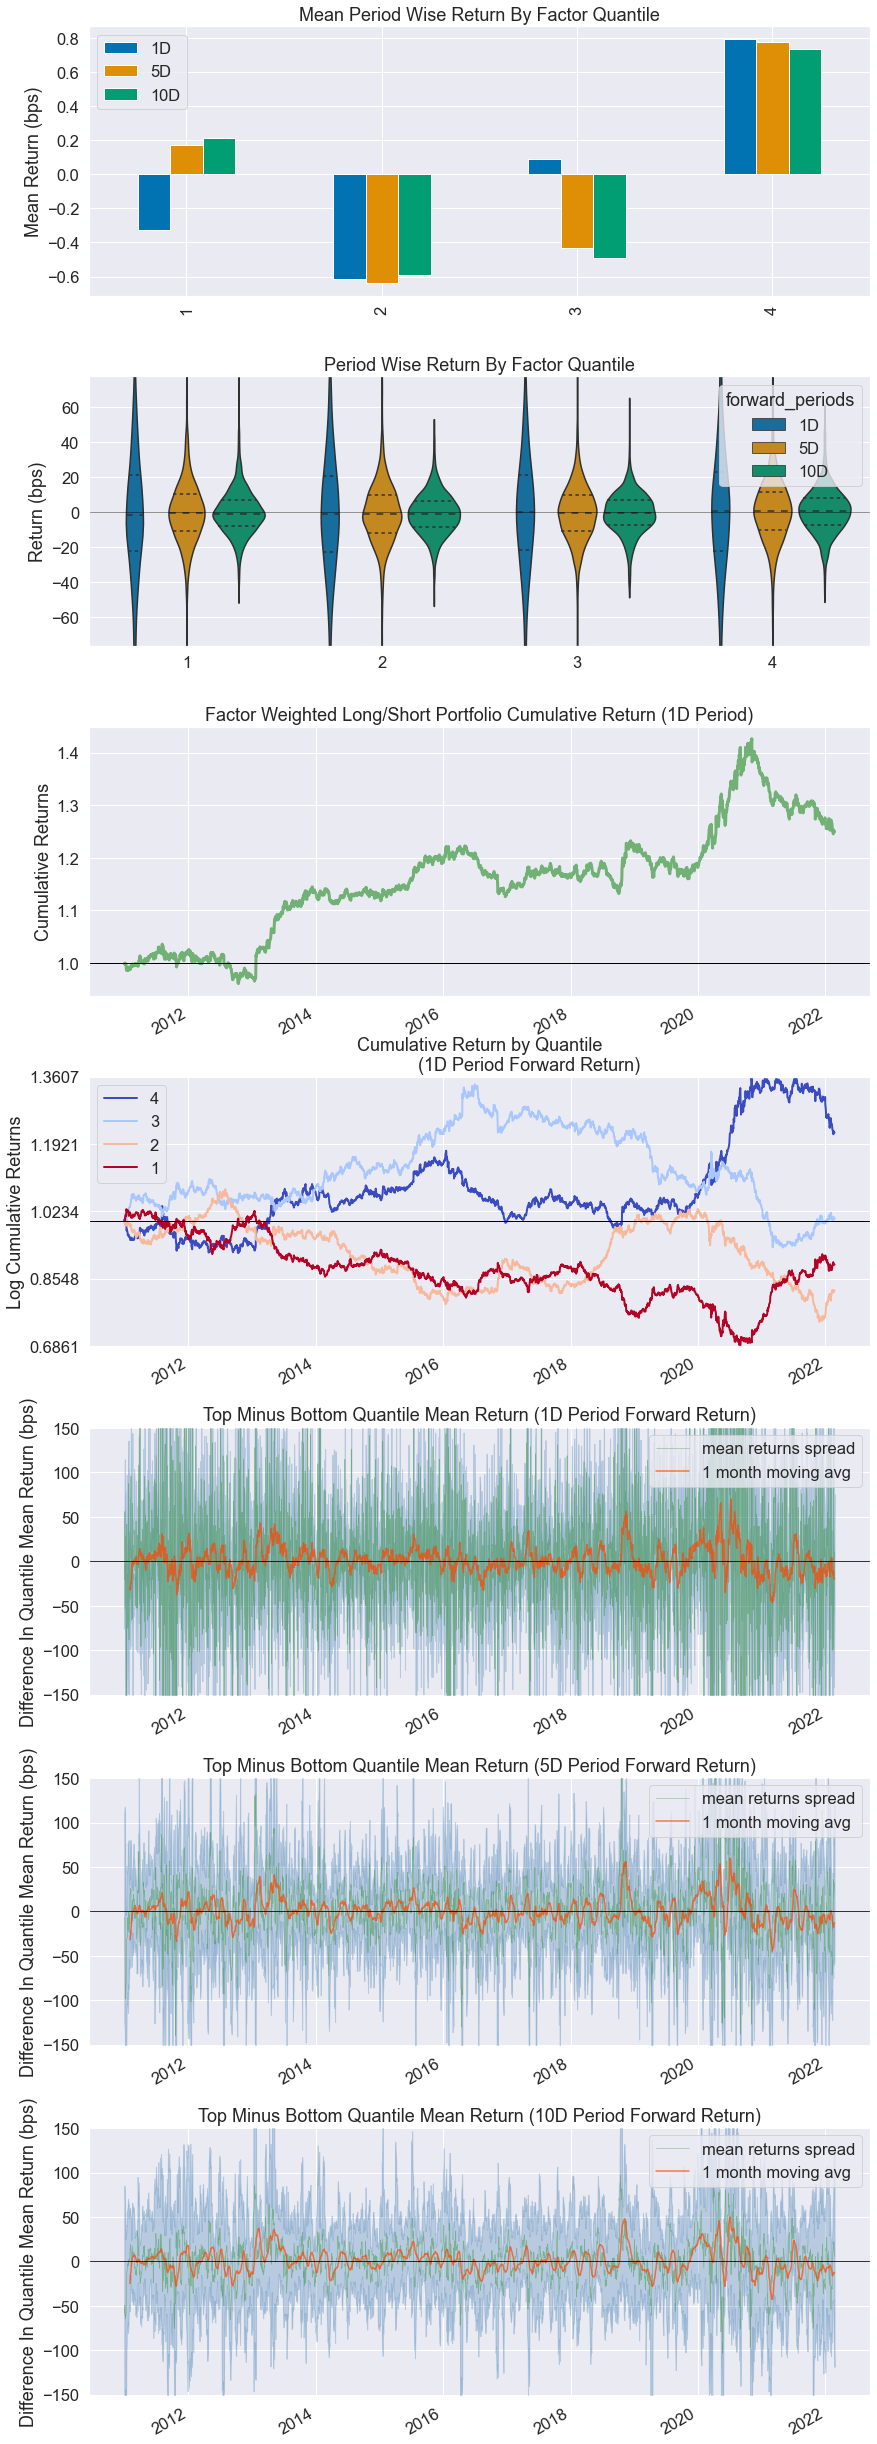

Information Analysis


1D     5D    10D
IC Mean           0.007  0.008  0.007
IC Std.           0.172  0.168  0.166
Risk-Adjusted IC  0.039  0.046  0.043
t-stat(IC)        2.079  2.439  2.260
p-value(IC)       0.038  0.015  0.024
IC Skew           0.051 -0.026 -0.083
IC Kurtosis      -0.092 -0.117 -0.218

/Users/leah/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/leah/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/leah/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexib

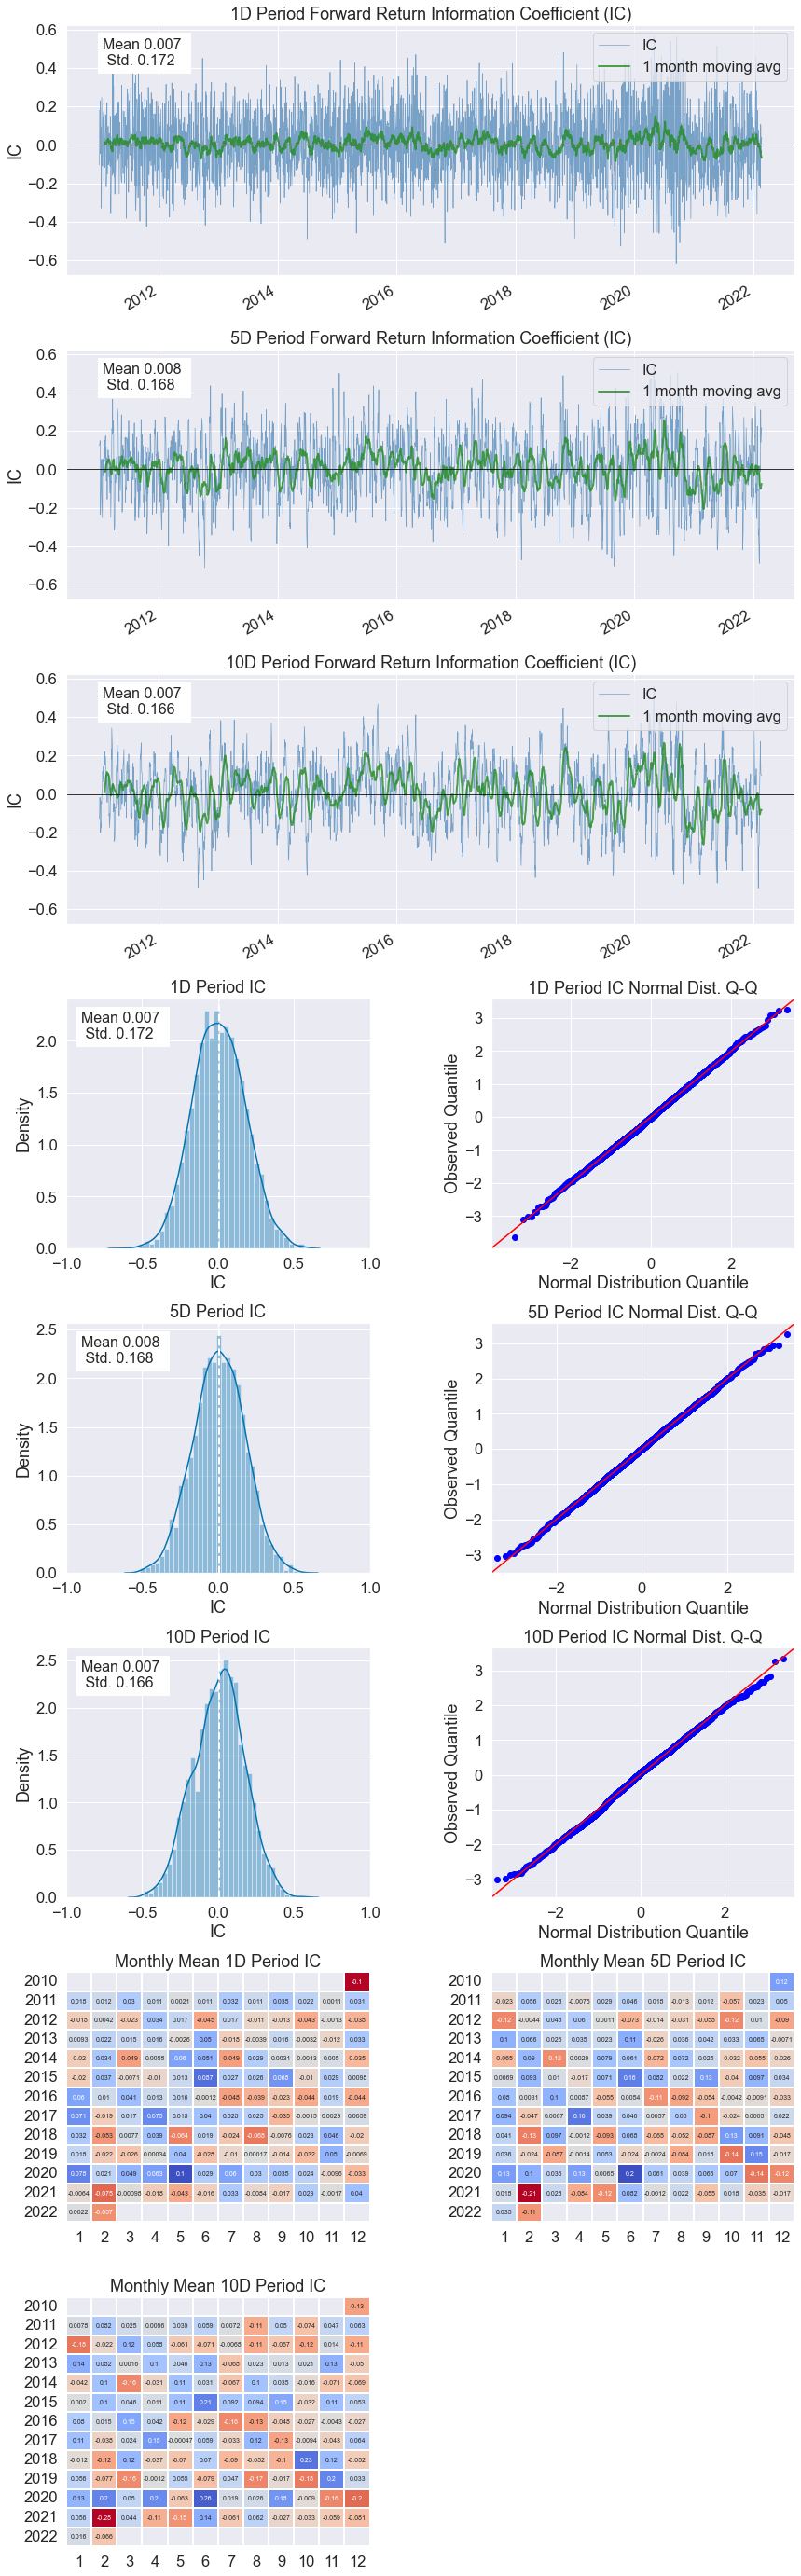

/Users/leah/opt/anaconda3/lib/python3.8/site-packages/alphalens/utils.py:910: UserWarning: Skipping return periods that aren't exact multiples of days.
  warnings.warn(


Turnover Analysis


1D     5D    10D
Quantile 1 Mean Turnover   0.011  0.046  0.084
Quantile 2 Mean Turnover   0.021  0.088  0.154
Quantile 3 Mean Turnover   0.023  0.094  0.165
Quantile 4 Mean Turnover   0.012  0.050  0.092

1D     5D    10D
Mean Factor Rank Autocorrelation  0.994  0.971  0.943

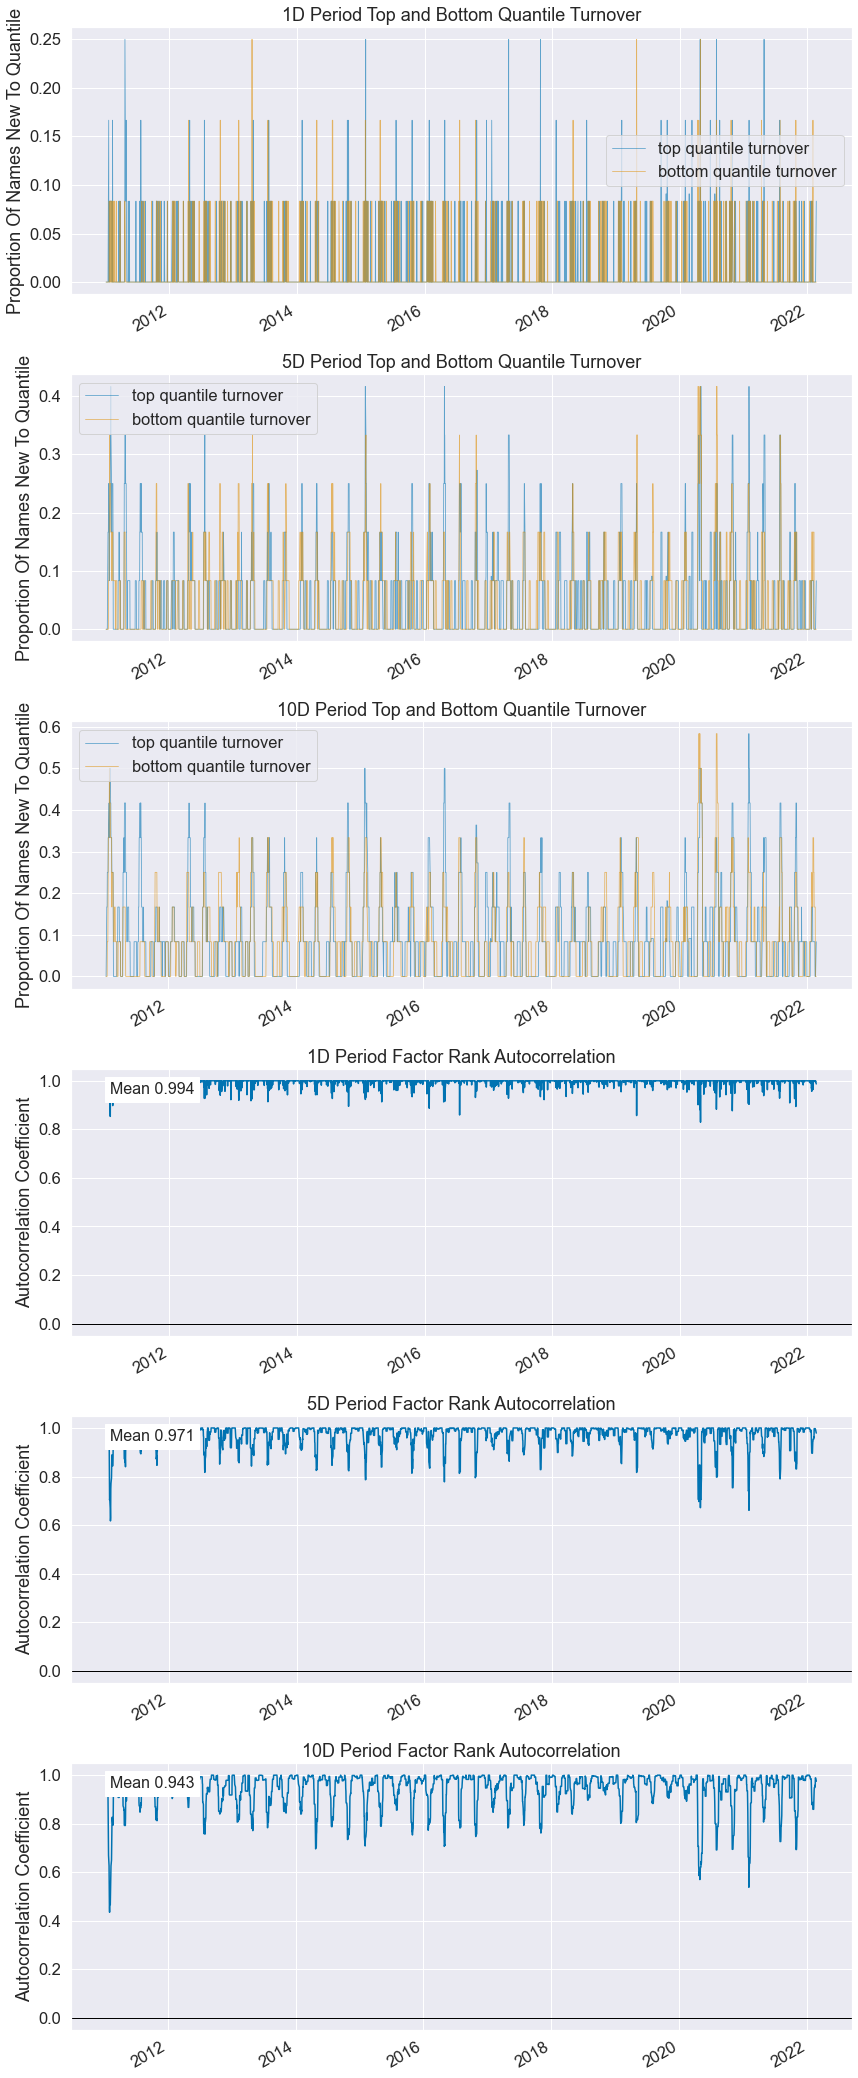

In [22]:
factor = 'Mean' 
factor_analysis(factor)

/var/folders/1f/ctsn5f0x2j1bynwzccj_sn2m0000gn/T/ipykernel_30547/1615834402.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  factors['Date'] = pd.to_datetime(factors['Date'], format = '%Y-%m-%d') # change date to time series


Dropped 0.4% entries from factor data: 0.4% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!
Quantiles Statistics


min     max       mean        std  count    count %
factor_quantile                                                       
1                 0.00   53.81  42.477780   8.691487  33714  26.131035
2                43.75   57.40  51.274658   2.105402  30883  23.936785
3                49.17   70.26  55.729326   2.389672  30805  23.876328
4                54.63  206.84  73.897402  23.190934  33617  26.055852

Returns Analysis


1D     5D    10D
Ann. alpha                                     0.010  0.007  0.008
beta                                          -0.040 -0.046 -0.057
Mean Period Wise Return Top Quantile (bps)    -0.583 -0.684 -0.632
Mean Period Wise Return Bottom Quantile (bps) -0.966 -0.739 -0.596
Mean Period Wise Spread (bps)                  0.383  0.044 -0.054

<Figure size 432x288 with 0 Axes>

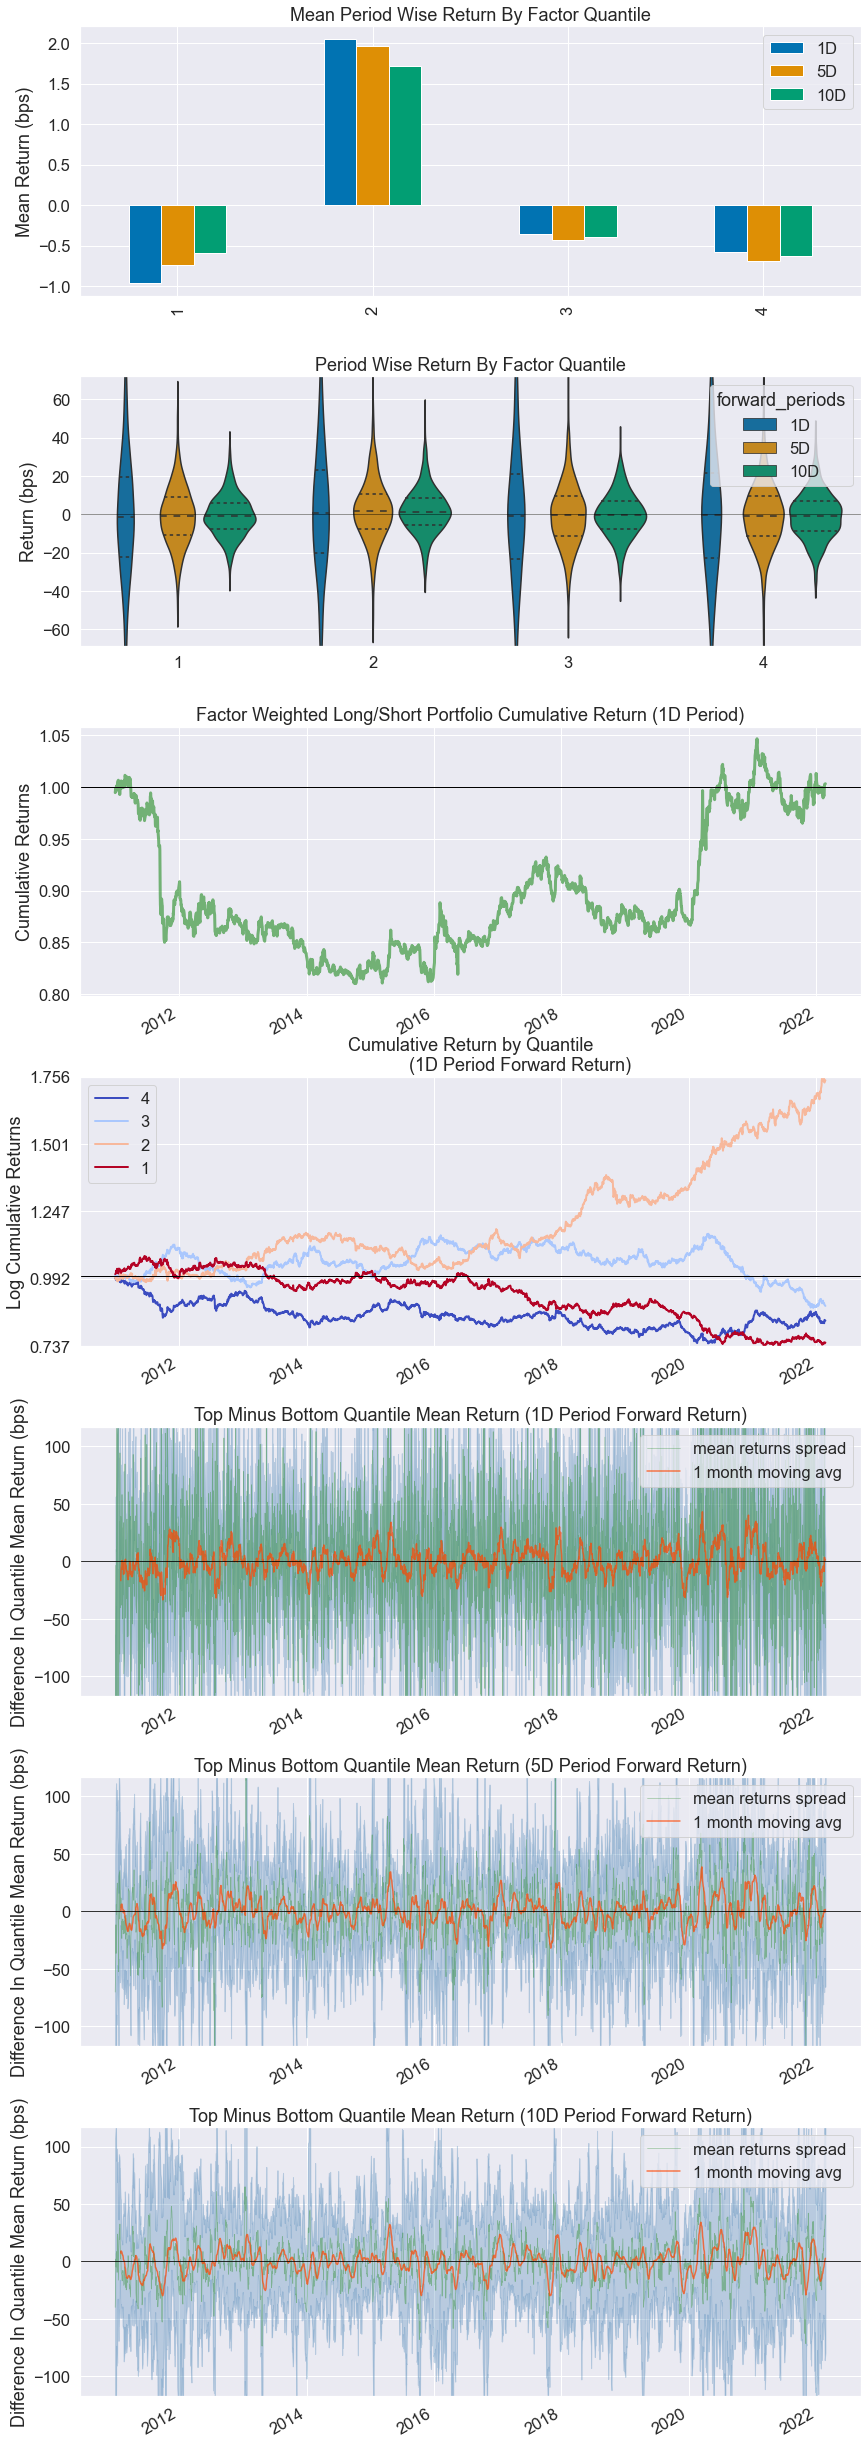

Information Analysis


1D     5D    10D
IC Mean           0.000 -0.003 -0.002
IC Std.           0.156  0.155  0.156
Risk-Adjusted IC  0.001 -0.021 -0.012
t-stat(IC)        0.040 -1.118 -0.653
p-value(IC)       0.968  0.264  0.514
IC Skew          -0.028  0.002 -0.027
IC Kurtosis      -0.047  0.026  0.091

/Users/leah/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/leah/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/leah/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexib

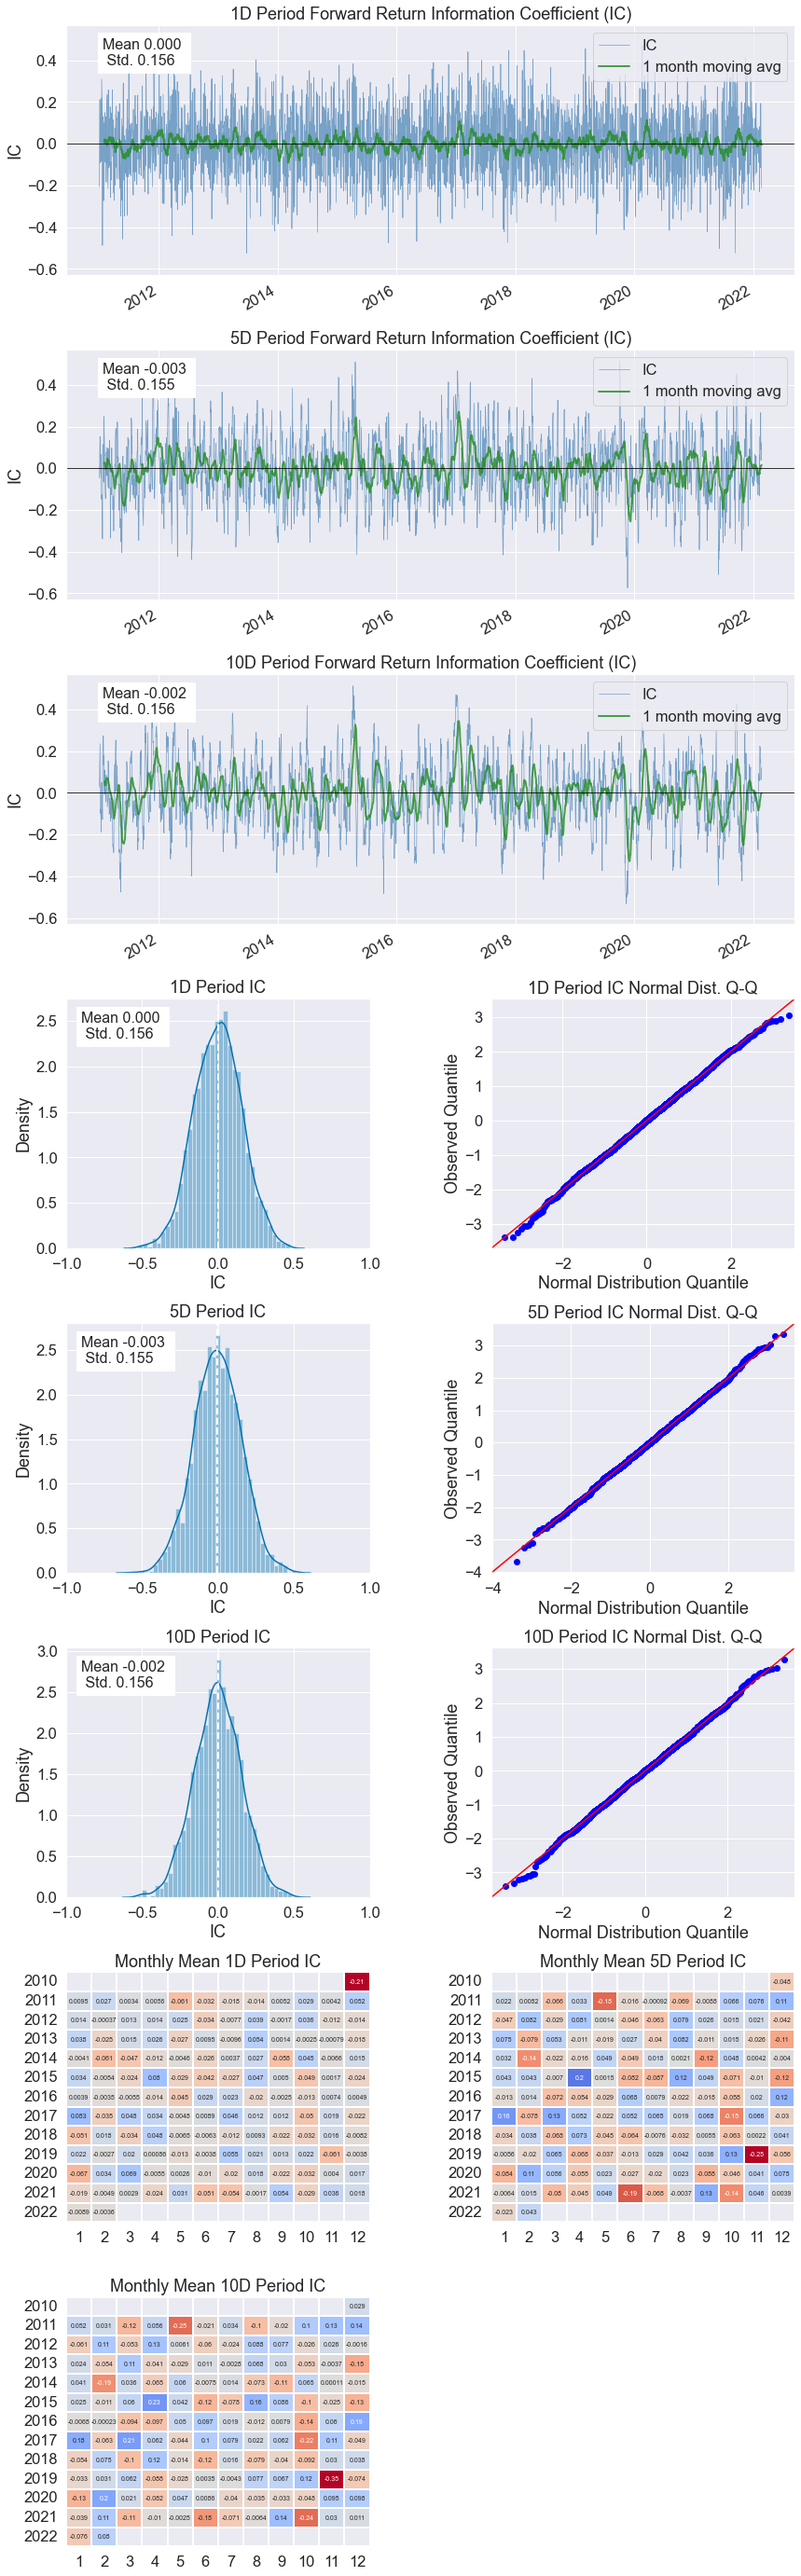

/Users/leah/opt/anaconda3/lib/python3.8/site-packages/alphalens/utils.py:910: UserWarning: Skipping return periods that aren't exact multiples of days.
  warnings.warn(


Turnover Analysis


1D     5D    10D
Quantile 1 Mean Turnover   0.014  0.059  0.107
Quantile 2 Mean Turnover   0.024  0.098  0.170
Quantile 3 Mean Turnover   0.024  0.094  0.162
Quantile 4 Mean Turnover   0.013  0.055  0.100

1D     5D    10D
Mean Factor Rank Autocorrelation  0.991  0.956  0.912

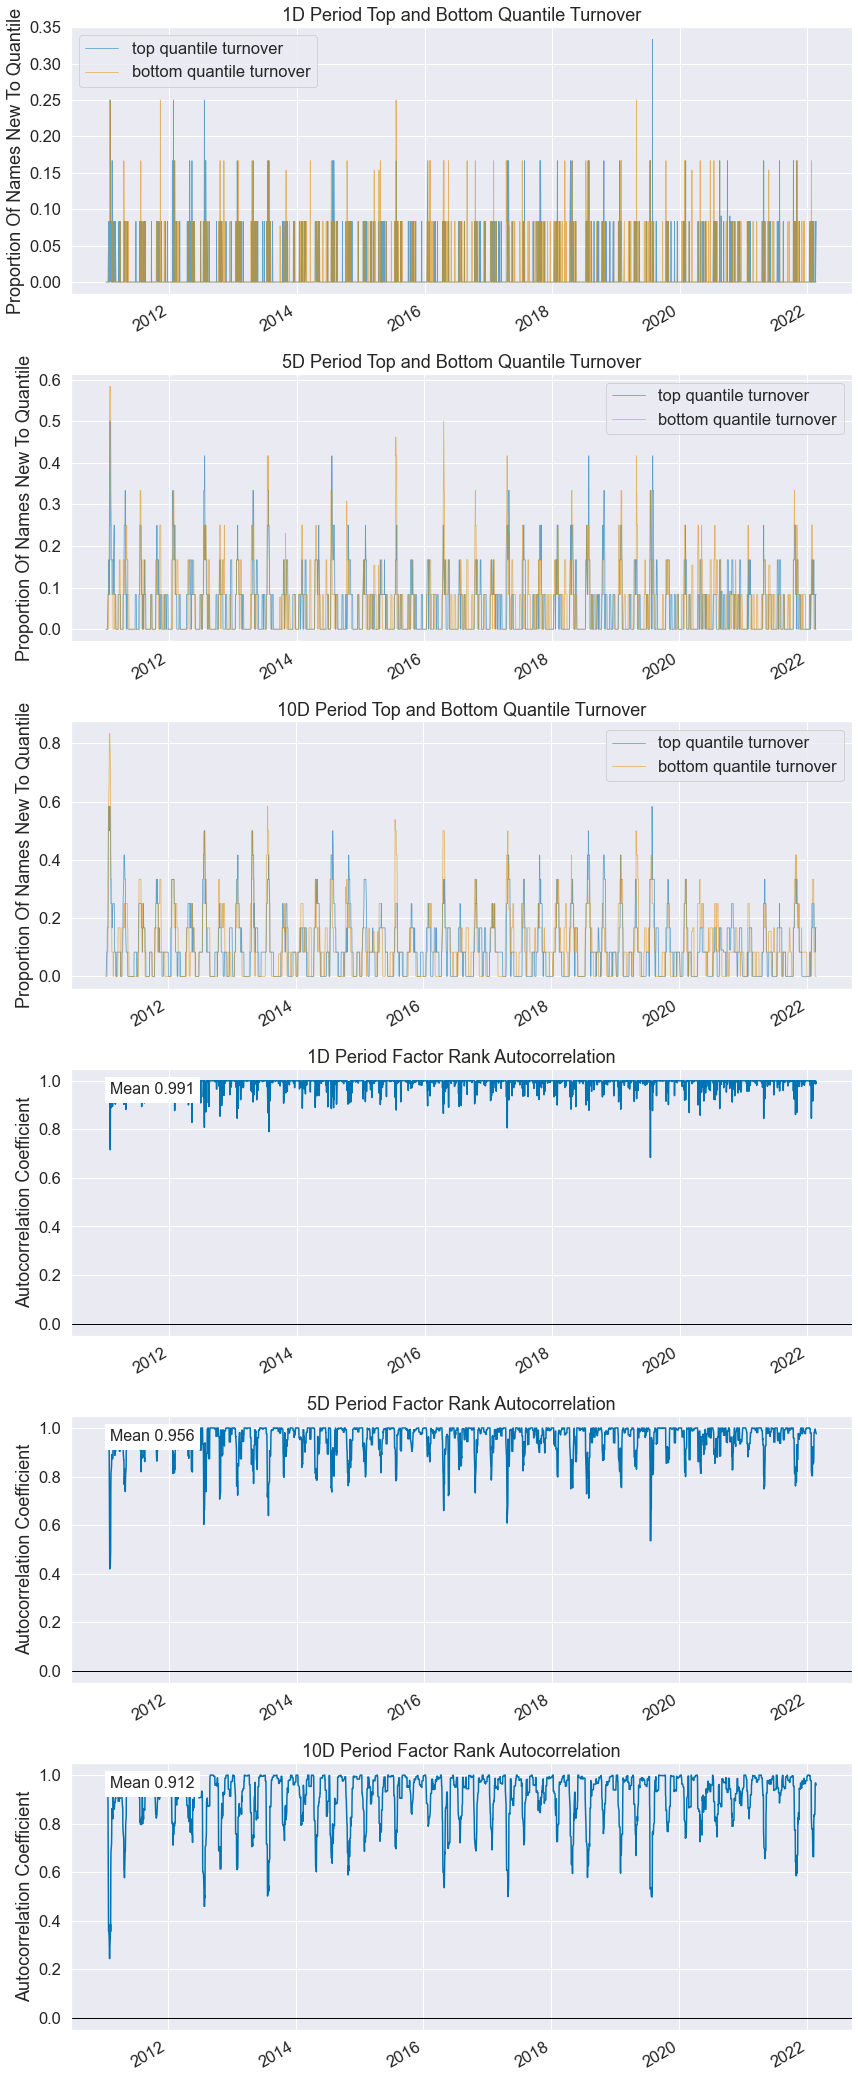

In [23]:
factor = 'Flesch score' 
factor_analysis(factor)

/var/folders/1f/ctsn5f0x2j1bynwzccj_sn2m0000gn/T/ipykernel_30547/1615834402.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  factors['Date'] = pd.to_datetime(factors['Date'], format = '%Y-%m-%d') # change date to time series


Dropped 0.4% entries from factor data: 0.4% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!
Quantiles Statistics


min     max      mean        std  count    count %
factor_quantile                                                     
1                0.00    3.30  2.339258   0.497579  33881  26.260473
2                2.13    3.79  3.097435   0.234456  31020  24.042970
3                2.93    4.42  3.556955   0.253509  30721  23.811222
4                3.19  255.00  7.859544  23.932506  33397  25.885335

Returns Analysis


1D     5D    10D
Ann. alpha                                    -0.002  0.002  0.001
beta                                          -0.019 -0.023 -0.021
Mean Period Wise Return Top Quantile (bps)    -1.028 -0.903 -0.977
Mean Period Wise Return Bottom Quantile (bps) -0.382 -0.122 -0.229
Mean Period Wise Spread (bps)                 -0.646 -0.767 -0.726

<Figure size 432x288 with 0 Axes>

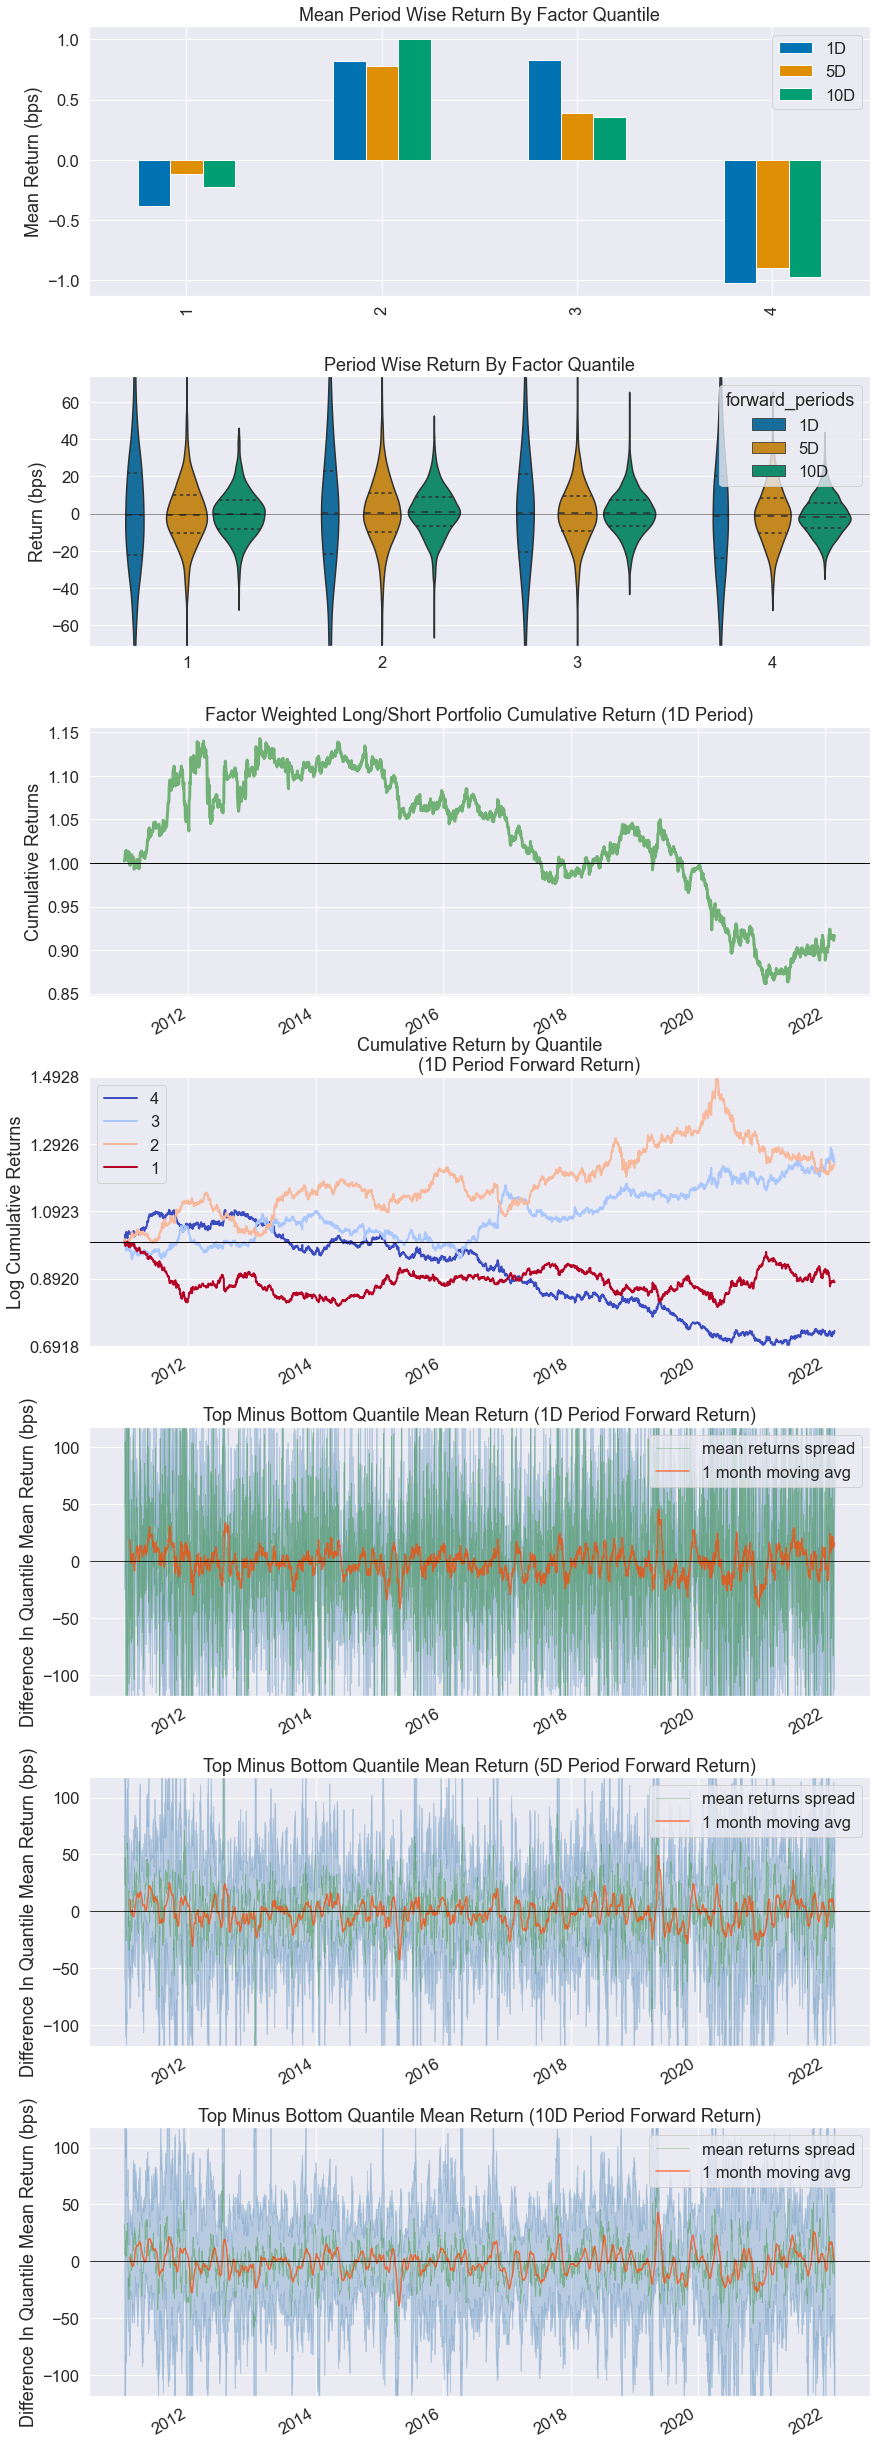

Information Analysis


1D     5D    10D
IC Mean          -0.000 -0.001 -0.005
IC Std.           0.161  0.159  0.160
Risk-Adjusted IC -0.001 -0.007 -0.030
t-stat(IC)       -0.072 -0.368 -1.599
p-value(IC)       0.942  0.713  0.110
IC Skew           0.011  0.018  0.079
IC Kurtosis      -0.051  0.196  0.083

/Users/leah/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/leah/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/leah/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexib

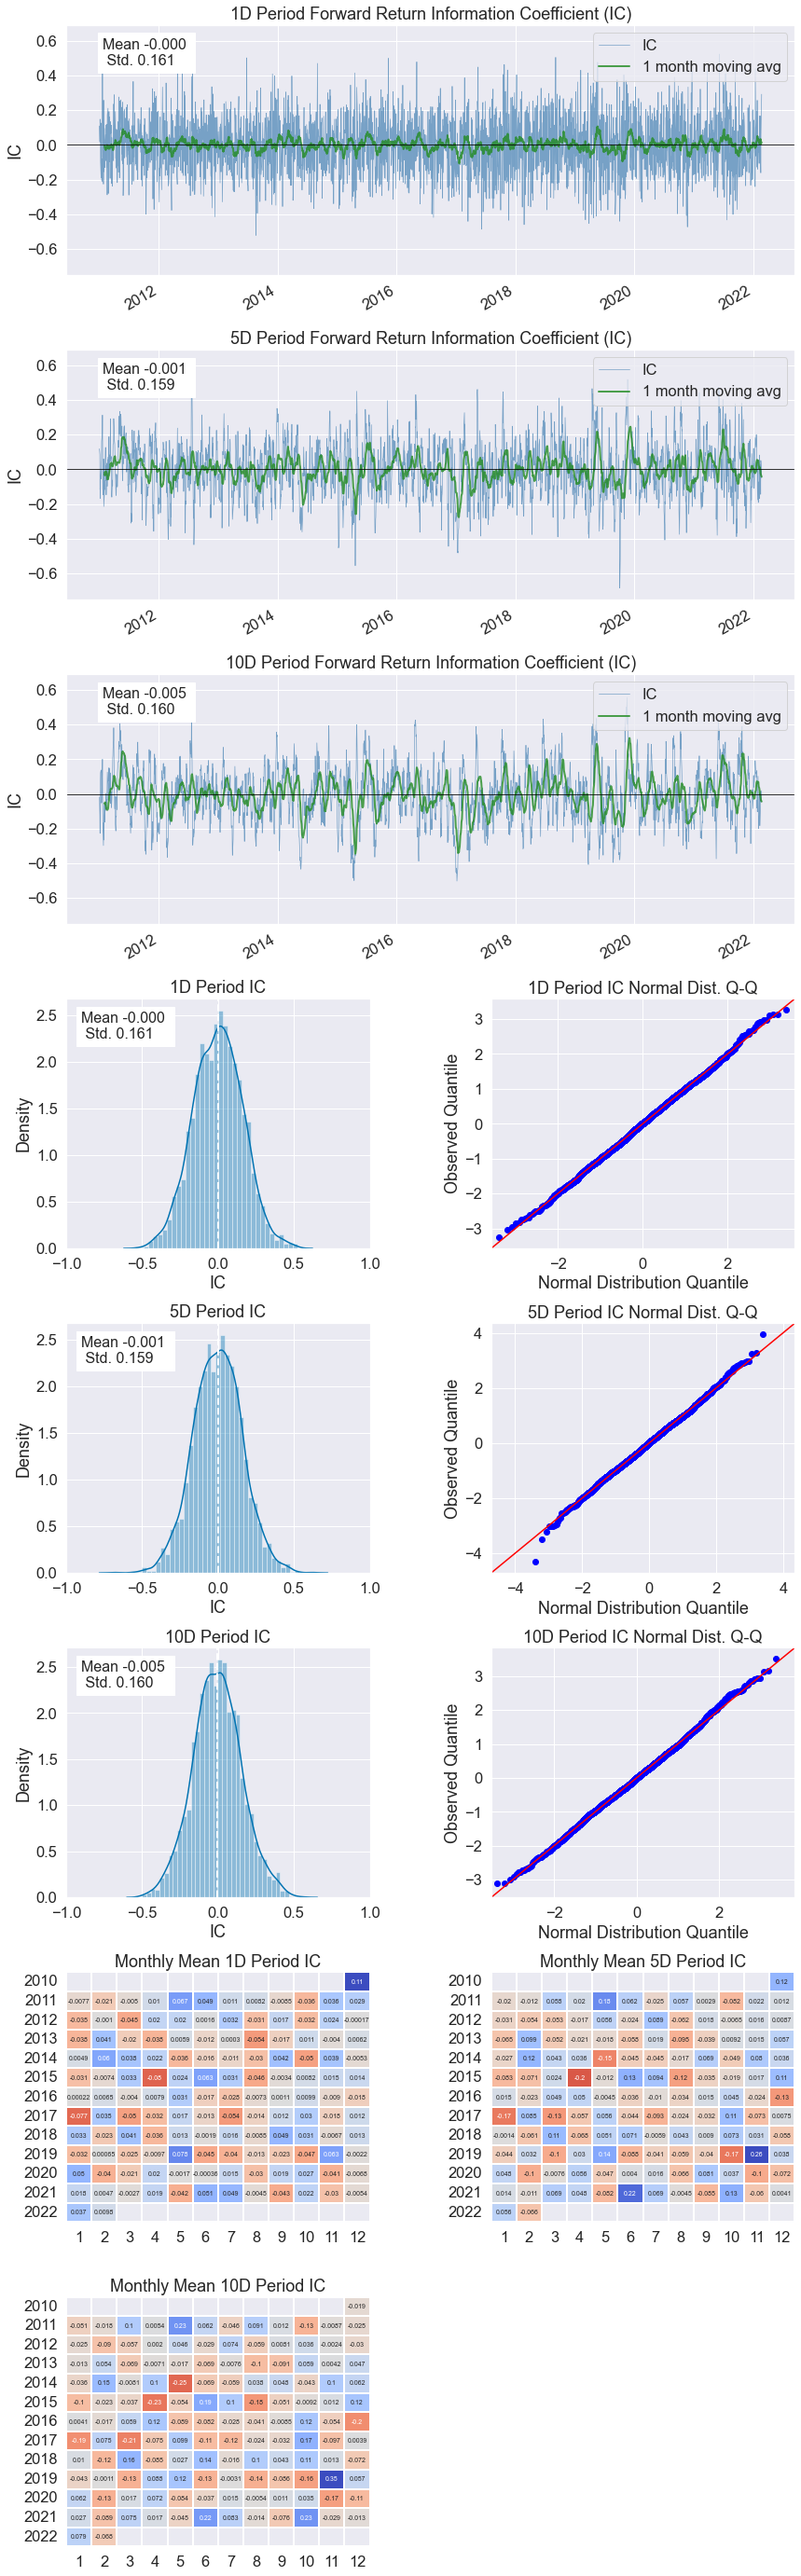

/Users/leah/opt/anaconda3/lib/python3.8/site-packages/alphalens/utils.py:910: UserWarning: Skipping return periods that aren't exact multiples of days.
  warnings.warn(


Turnover Analysis


1D     5D    10D
Quantile 1 Mean Turnover   0.013  0.054  0.096
Quantile 2 Mean Turnover   0.024  0.096  0.165
Quantile 3 Mean Turnover   0.024  0.098  0.171
Quantile 4 Mean Turnover   0.013  0.057  0.103

1D     5D    10D
Mean Factor Rank Autocorrelation  0.992  0.962  0.924

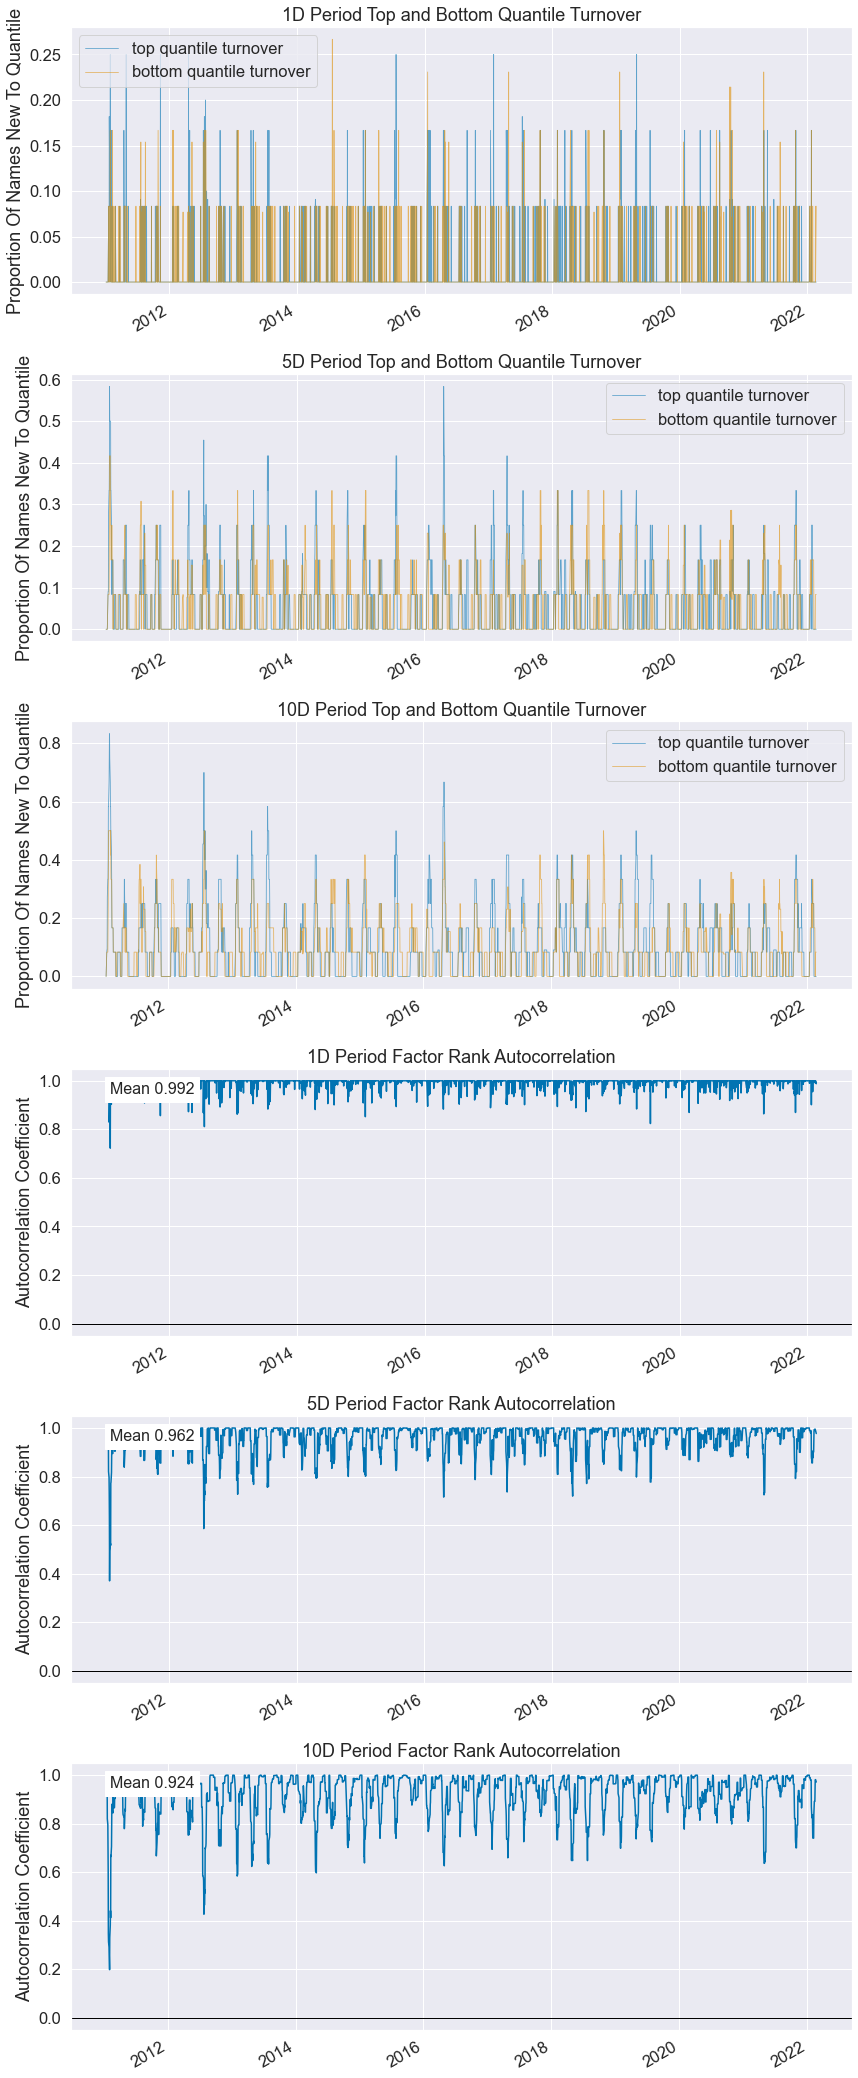

In [24]:
factor = 'Polysyllable number per sentence' 
factor_analysis(factor)